In [2]:
from src.generate_surfaces import ResponseFunction, six_curve_sum
import torch
from ax import Client, RangeParameterConfig
from src import BO_visuals

# Single prediction

## initialise response and client

In [3]:
simple_func = lambda x: sum(x)

resp = ResponseFunction(simple_func, 3)
# 1. Initialize the Client.
client = Client()



## configure the search domain

In [4]:
# 2. Configure where Ax will search.
client.configure_experiment(
    name="booth_function",
    parameters=[
        RangeParameterConfig(
            name=f"x{i}",
            bounds=(0, 20.0),
            parameter_type="float",
        ) for i in range(3)
    ],
)

In [5]:
# 3. Configure a metric for Ax to target (see other Tutorials for adding constraints,
# multiple objectives, tracking metrics etc.)
client.configure_optimization(objective="booth")

In [6]:
# 4. Conduct the experiment with 20 trials: get each trial from Ax, evaluate the
# objective function, and log data back to Ax.
for _ in range(20):
    # Use higher value of `max_trials` to run trials in parallel.
    for trial_index, parameters in client.get_next_trials(max_trials=1).items():
        coordinates = torch.tensor(
            [[parameters[f"x{i}"]] for i in range(3)], dtype=torch.float32
        )
        #print(coordinates)
        #print(resp.evaluate(coordinates)[0])

        client.complete_trial(
            trial_index=trial_index,
            raw_data={
            "booth": resp.evaluate(coordinates)[0].item()
            },
        )

# 5. Obtain the best-performing configuration; the true minimum for the booth

client.get_best_parameterization()

[INFO 09-15 09:27:17] ax.api.client: GenerationStrategy(name='Center+Sobol+MBM:fast', nodes=[CenterGenerationNode(next_node_name='Sobol'), GenerationNode(node_name='Sobol', generator_specs=[GeneratorSpec(generator_enum=Sobol, model_key_override=None)], transition_criteria=[MinTrials(transition_to='MBM'), MinTrials(transition_to='MBM')]), GenerationNode(node_name='MBM', generator_specs=[GeneratorSpec(generator_enum=BoTorch, model_key_override=None)], transition_criteria=[])]) chosen based on user input and problem structure.
[INFO 09-15 09:27:17] ax.api.client: Generated new trial 0 with parameters {'x0': 10.0, 'x1': 10.0, 'x2': 10.0} using GenerationNode CenterOfSearchSpace.
[INFO 09-15 09:27:17] ax.api.client: Trial 0 marked COMPLETED.
[INFO 09-15 09:27:17] ax.api.client: Generated new trial 1 with parameters {'x0': 16.417418, 'x1': 4.130445, 'x2': 2.122312} using GenerationNode Sobol.
[INFO 09-15 09:27:17] ax.api.client: Trial 1 marked COMPLETED.
[INFO 09-15 09:27:17] ax.api.client: 

({'x0': 20.0, 'x1': 20.0, 'x2': 20.0}, {'booth': (60.0, nan)}, 8, '8_0')

In [7]:
import pandas as pd
from src.BO_visuals import show_point


print("Results DataFrame:")
print(show_point.get_trial_data(client))
results = show_point.get_trial_data(client)

Results DataFrame:
           x0         x1         x2   response
0   10.000000  10.000000  10.000000  30.000000
1   16.417418   4.130445   2.122312  22.670176
2    0.785418  16.283629  15.563317  32.632362
3    8.454932   8.171400   6.620774  23.247105
4   14.067439  10.949895  10.674275  35.691608
5   16.258543  12.699096  12.883194  41.840832
6   20.000000  14.463820  15.307841  49.771664
7   20.000000  18.526168  20.000000  58.526169
8   20.000000  20.000000  20.000000  60.000000
9   20.000000  20.000000   9.526717  49.526718
10  18.640179  20.000000  20.000000  58.640179
11  19.011803  20.000000  20.000000  59.011803
12  12.102644   3.555520  17.815315  33.473480
13   6.222485  11.110700   7.546093  24.879276
14   3.997343   5.492625  14.942848  24.432816
15  17.999986  17.967239   4.676067  40.643291
16  16.755553   9.982237   6.852348  33.590137
17   0.250473  17.221979  16.497791  33.970245
18   9.978967   1.565338   1.013267  12.557573
19  13.356690  14.354398  10.656269  38.3

In [8]:
from math import floor
from botorch.models import SingleTaskGP
from botorch.fit import fit_gpytorch_mll_torch
from gpytorch.mlls import ExactMarginalLogLikelihood
from torch._tensor import Tensor
import importlib
import math
import seaborn as sns

import matplotlib.pyplot as plt

In [9]:
%matplotlib
%matplotlib notebook
%matplotlib inline

Using matplotlib backend: module://matplotlib_inline.backend_inline


In [10]:
importlib.reload(show_point)  # Reload to get latest changes
importlib

<module 'importlib' from 'C:\\Users\\326po\\AppData\\Local\\Programs\\Python\\Python313\\Lib\\importlib\\__init__.py'>

C:\Users\326po\AppData\Local\Temp\ipykernel_6792\866377137.py:10: InputDataWarning:

The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444

c:\Users\326po\AppData\Local\pypoetry\Cache\virtualenvs\bo-coli-wM2eEb6D-py3.13\Lib\site-packages\botorch\models\utils\assorted.py:270: InputDataWarning:

Data (input features) is not contained to the unit cube. Please consider min-max scaling the input data.



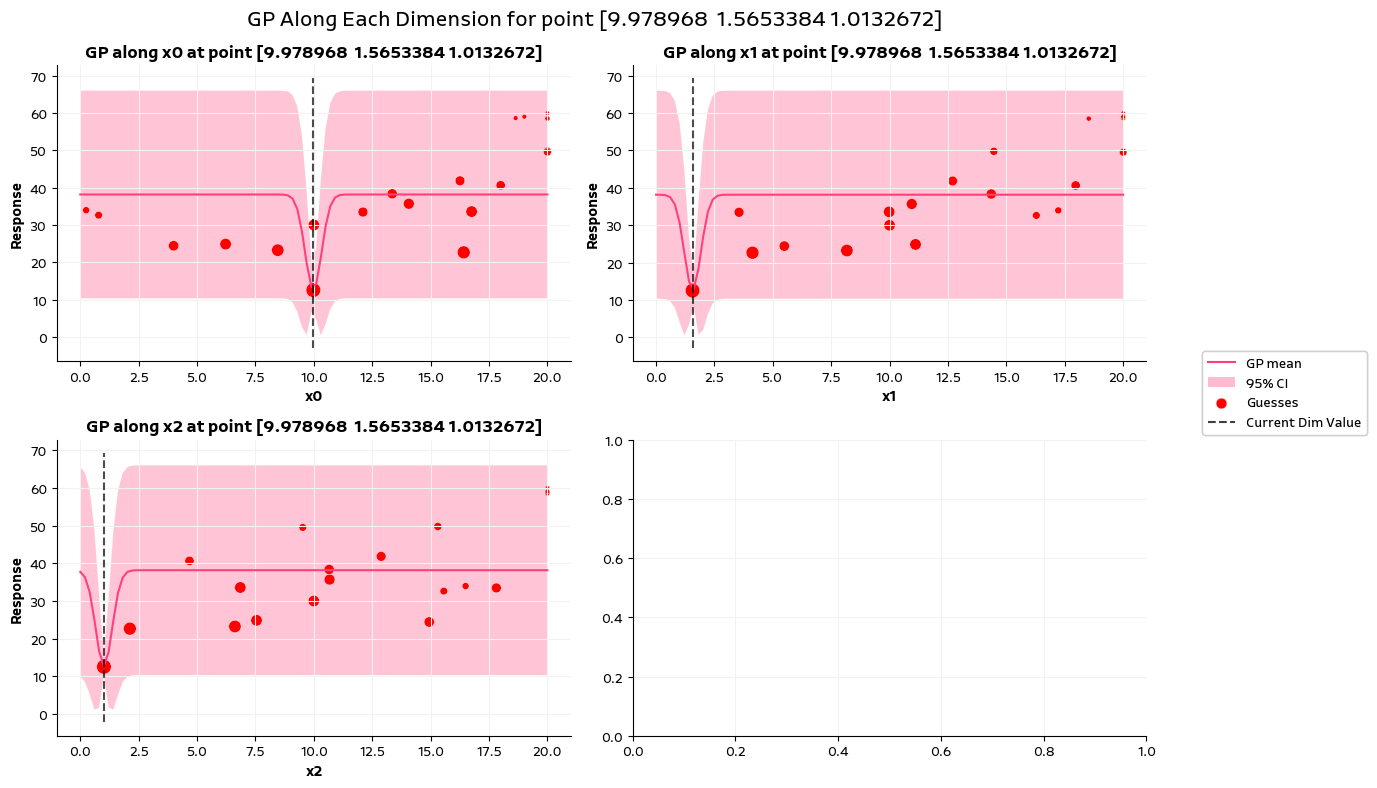

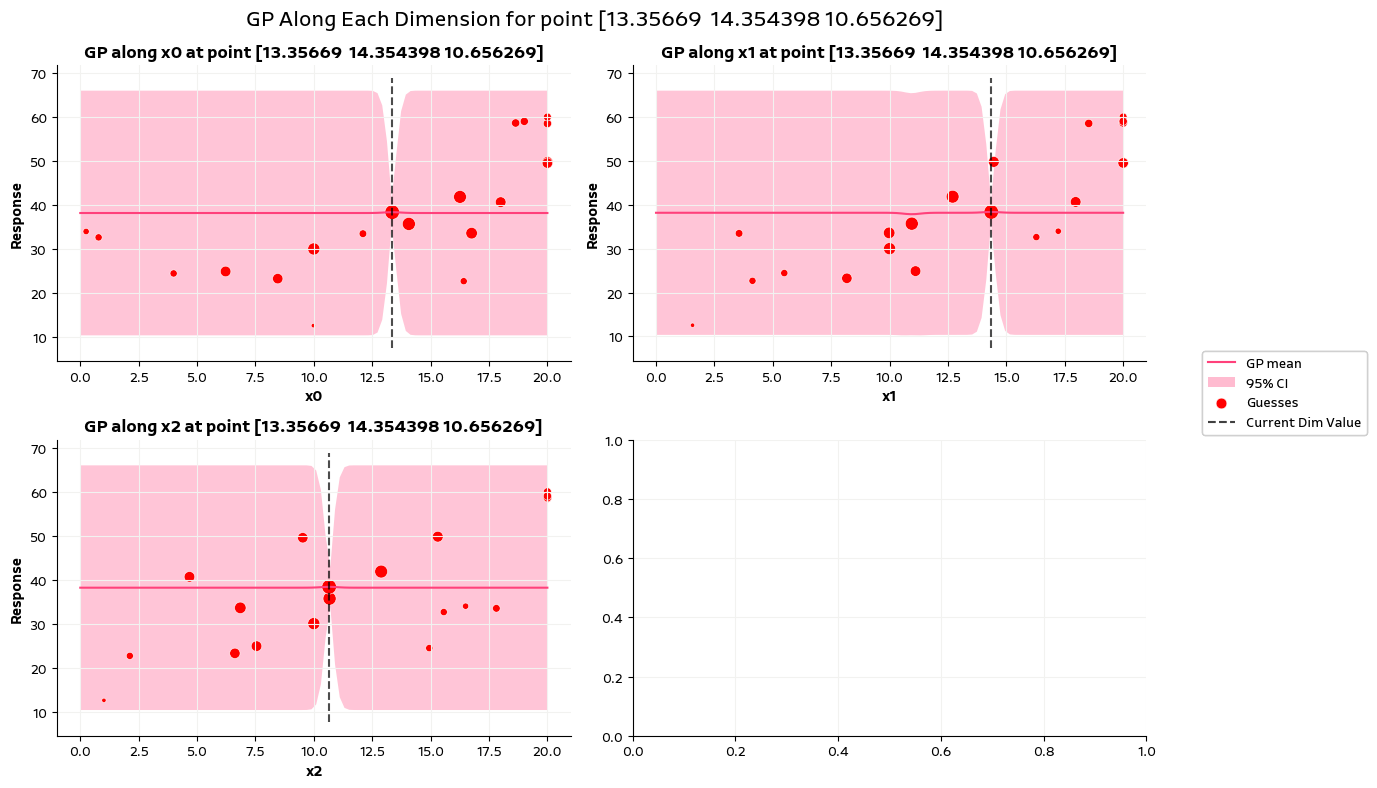

In [25]:
importlib.reload(BO_visuals)  # Reload to get latest changes
importlib.reload(BO_visuals.show_point)  # Reload to get latest changes
importlib.reload(BO_visuals.plt_runner)  # Reload to get latest changes

importlib.reload(show_point)  # Reload to get latest changes


train_X, train_Y = show_point.get_train_Xy(results, response_col='response')

gp = SingleTaskGP(train_X, train_Y)


def grid_dims(results_df) -> tuple[int, int]:
    """Get grid dimensions for plotting based on number of results."""
    n = results_df.shape[1] - 1  # Exclude response column
    length = math.ceil(n**0.5)
    return length, math.ceil(n / length)

def plt_gp_along_dimension(grid: Tensor, mean: Tensor, std: Tensor, results: pd.DataFrame, ax: plt.Axes):
    """Plot GP mean and confidence intervals along a single dimension."""
    ax.plot(grid.numpy(), mean, label='GP mean')
    ax.fill_between(grid.numpy(), mean - 2*std, mean + 2*std, alpha=0.3, label='95% CI')
    


def get_euclidean_distance(point1: list[float]|Tensor, point2: list[float]|Tensor) -> float:
    """Calculate Euclidean distance between two points."""
    if not isinstance(point1, Tensor):
        point1 = torch.tensor(point1, dtype=torch.float32)
    if not isinstance(point2, Tensor):
        point2 = torch.tensor(point2, dtype=torch.float32)
    return torch.dist(point1, point2).item()


def plt_gp_all_dims(gp: SingleTaskGP, results_df: pd.DataFrame, coordinates: list[float]|Tensor):

    fig, axs = plt.subplots(*grid_dims(results_df), figsize=(12, 8))
    axs = axs.flatten()

    coordinates = coordinates.numpy() if isinstance(coordinates, Tensor) else coordinates

    plt.suptitle(f'GP Along Each Dimension for point {coordinates}', fontsize=16)

    for i in range(results_df.shape[1]-1):
        ax = axs[i]

        grid = torch.linspace(0, 20, 100)
        mean, std = show_point.get_plane_gaussian_for_point(gp, coordinates, fixed_dim=i, grid=grid)

        distances = [get_euclidean_distance(coordinates, row[:-1]) for row in results_df.to_numpy()]
        point_size = [(1 - d / max(distances)) * 100 + 10 for d in distances]  # Scale sizes





        plt_gp_along_dimension(grid, mean, std, results_df, ax)

        ax.set_xlabel(results_df.columns[i])
        ax.set_ylabel('Response')
        ax.set_title(f'GP along {results_df.columns[i]} at point {coordinates}')

        sns.scatterplot(x=results_df[f'x{i}'], y=results_df['response'], color='red', label='Guesses', ax=ax, s=point_size)

        sns.scatterplot(x=[coordinates[i]], y=[simple_func(coordinates)], color='blue', label='Current Point', ax=ax, s=100, marker='X')

        ax.legend().set_visible(False)

        # Move legend to the right outside the entire figure
        handles, labels = axs[0].get_legend_handles_labels()
        fig.legend(handles, labels, loc='center left', bbox_to_anchor=(1, 0.5))
        plt.tight_layout(rect=[0, 0, 0.98, 1])



for point in results.itertuples():
    if point.Index < 18:
        continue  # Skip to later points for more interesting plots

    grid = torch.linspace(0, 20, 100)

    coordinates = torch.tensor([point.x0, point.x1, point.x2], dtype=torch.float32)

    
    BO_visuals.plt_gp_all_dims(gp, results, coordinates)
    plt.show()

